In [23]:
from pathlib import Path
from typing import Sequence

import matplotlib.axes._axes as axes
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import Figure

In [24]:
PATH = Path(r"C:\Users\balco\Downloads\phd_data")
DAY_INDEX = [1, 3, 25, 27]
FOLDER_INDEX = [1, 2, 3, 4]
DAY_ALONE_INDEX = 15

CB91_Blue = "#2CBDFE"
CB91_Green = "#47DBCD"
CB91_Pink = "#F3A0F2"
CB91_Purple = "#9D2EC5"
CB91_Violet = "#661D98"
CB91_Amber = "#F5B14C"

color_list = [
    CB91_Blue,
    CB91_Amber,
    CB91_Green,
    CB91_Violet,
    CB91_Pink,
    CB91_Purple,
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_list)

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

In [25]:
def mean_across_dataframes(dfs: Sequence[pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(dfs).groupby(level=0).mean()


def read_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", drop=True, inplace=True)

    return df


def get_dirs(name: str):
    """Get all directories which contain the specified word in their name"""
    return PATH.glob(f"*{name}*")


def get_file_from_dir(dir_: Path, index: int):
    """Get the csv at the specified position"""
    return list(dir_.glob("*.csv"))[index]


def get_files(name: str, index: int):
    """
    Get the csv files at the specified position for all the directories which contain the word `name`
    """
    return (get_file_from_dir(d, index) for d in get_dirs(name))


def combine_df(
    dfs: Sequence[pd.DataFrame], names: Sequence[str], feature: str = "Power", feat_opt: str = "Optimum Power"
) -> pd.DataFrame:
    """
    Combine multiple dataframes into a single one
    """

    combined_df = {}

    if feat_opt:
        combined_df[names[-1]] = dfs[0][feat_opt]

    for df, name in zip(dfs, names):
        combined_df[name] = df[feature]

    return pd.DataFrame(combined_df)


def plot_combined(df: pd.DataFrame, ylabel: str = "", multiplier: int = 1) -> Figure:

    fig = plt.figure()
    ax: axes.Axes = fig.add_subplot(111)

    effs = compute_eff(df)

    for column, eff in zip(df.columns, effs):
        label = f'{column}, {eff:.2f}%'
        ax.plot(df.index, df[column] * multiplier, label=label)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc="upper left")

    ax.set_ylabel(ylabel)

    return fig


def compute_eff(df: pd.DataFrame) -> pd.DataFrame:
    df1 = df.mean()

    # names = df1.index[:]
    return df1.values[:] * 100

In [26]:
# def read_csv(path: Path) -> pd.DataFrame:
#     df = pd.read_csv(path)
#     df["Date"] = pd.to_datetime(df["Date"])
#     df.set_index("Date", drop=True, inplace=True)

#     return df


# def plot(df: pd.DataFrame):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)

#     for col in df.columns:
#         if "Amb" in col:
#             continue  # Skip ambient temperatures
#         ax.plot(df.index, df[col], label=LEGEND[col])
#         ax.xaxis.set_major_locator(locator)
#         ax.xaxis.set_major_formatter(formatter)
#         ax.set_ylabel("Irradiancia solar $\mathrm{(W/m^2)}$")
#         ax.legend(loc="upper left")

#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
    

#     return fig

# def add_year_offset(df: pd.DataFrame) -> pd.DataFrame:
#     df.index = df.index + pd.DateOffset(years=1)
#     return df


# def split_df_by_day(df: pd.DataFrame) -> Sequence[pd.DataFrame]:
#     return [group[1] for group in df.groupby(df.index.date)]

In [27]:
def main_plot_train_day():
    for i, folder in enumerate(FOLDER_INDEX, start=1):
        po_train_files = [list(get_files("po_train", DAY_ALONE_INDEX))[0]]
        ddpg_train_files = [list(get_files("ddpg_train", DAY_ALONE_INDEX))[folder]]
        td3_train_files = [list(get_files("td3_train", DAY_ALONE_INDEX))[folder]]
        td4_train_files = [list(get_files("td3exp_train", DAY_ALONE_INDEX))[folder]]

        assert len(po_train_files) == 1
        assert len(ddpg_train_files) == 1
        assert len(td3_train_files) == 1
        assert len(td4_train_files) == 1

        print(po_train_files)
        print(ddpg_train_files)
        print(td3_train_files)
        print(td4_train_files)

        po_mean = mean_across_dataframes(read_csv(f) for f in po_train_files)
        ddpg_mean = mean_across_dataframes((read_csv(f) for f in ddpg_train_files))
        td3_mean = mean_across_dataframes((read_csv(f) for f in td3_train_files))
        td4_mean = mean_across_dataframes((read_csv(f) for f in td4_train_files))

        df = combine_df(
            [po_mean, ddpg_mean, td3_mean, td4_mean],
            ["P\&O","DDPG", "TD3", "TD4"],
            feature="Efficiency", feat_opt=None
        )

        p = plot_combined(df, ylabel="Efficiencia (\%)", multiplier=100)

        p.savefig(f"output\\fig_12_mppt_comparison_train_efficiency_{i:02}.pdf", bbox_inches="tight")

    return df

[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-07-31_21-51-53_po_train/2021-07-31_21-52-27.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-07-31_23-11-21_ddpg_train/2021-07-31_23-12-52.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-07-31_23-23-58_td3_train/2021-07-31_23-25-52.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-07-31_23-55-51_td3exp_train/2021-07-31_23-59-08.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-07-31_21-51-53_po_train/2021-07-31_21-52-27.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-08-01_00-16-57_ddpg_train/2021-08-01_00-18-31.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-08-01_00-29-40_td3_train/2021-08-01_00-31-34.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-08-01_01-01-31_td3exp_train/2021-08-01_01-04-49.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/2021-07-31_21-51-53_po_train/2021-07-31_21-52-27.csv')]
[WindowsPath('C:/Users/balco/Downloads/phd_data/20

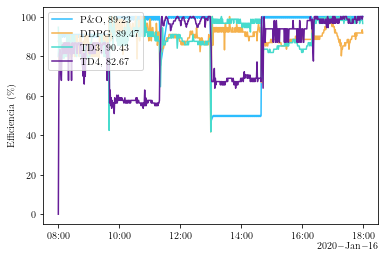

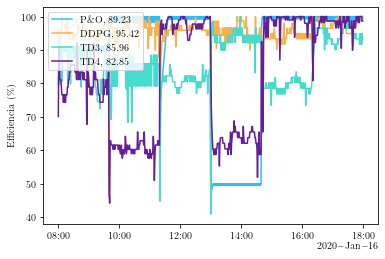

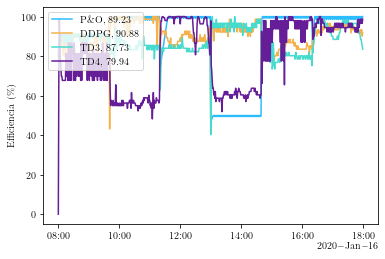

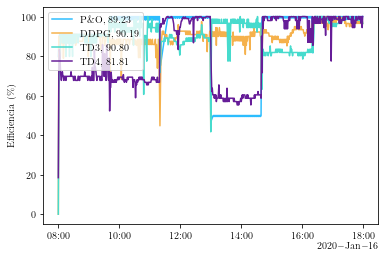

In [28]:
df = main_plot_train_day()

In [29]:
df

,P\&O,DDPG,TD3,TD4
Date,,,,
2020-01-16 08:00:00,0.797920,0.000000,0.000000,0.184914
2020-01-16 08:01:00,0.866369,0.899672,0.633755,0.720478
2020-01-16 08:02:00,0.904342,0.804839,0.789423,0.833071
2020-01-16 08:03:00,0.909740,0.788686,0.788686,0.810825
2020-01-16 08:04:00,0.895202,0.797920,0.909740,0.743269
...,...,...,...,...
2020-01-16 17:55:00,1.000000,0.965046,0.980591,1.000000
2020-01-16 17:56:00,0.985262,0.965046,0.980591,0.965869
2020-01-16 17:57:00,1.000000,0.980591,0.965046,1.000000


In [30]:
compute_eff(df)

array([89.23051346, 90.18968184, 90.80143684, 81.80694383])

In [31]:
df1 = df.mean() * 100

In [32]:
df1.values

array([89.23051346, 90.18968184, 90.80143684, 81.80694383])

In [33]:
type(df1)

pandas.core.series.Series